<a href="https://colab.research.google.com/github/ziwenwang28/QSVM_on_Synthetic_Datasets/blob/main/Quantum_SVM_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit_machine_learning
!pip install qiskit_aer
!pip install qiskit

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 100.0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        25
           1       0.39      0.65      0.49        20

    accuracy                           0.40        45
   macro avg       0.41      0.43      0.38        45
weighted avg       0.41      0.40      0.37        45

Classical SVM training time with PCA: 0.0027163028717041016 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        25
           1       0.40      0.40      0.40        20

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.46        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 56.91037583351135 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52        25
           1       0.46      0.55      0.50        20

    accuracy                           0.51        45
   macro avg       0.51      0.52      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 38.7445125579834 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        25
           1       0.41      0.35      0.38        20

    accuracy                           0.49        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.48      0.49      0.48        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 228.48776006698608 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        25
           1       0.43      0.45      0.44        20

    accuracy                           0.49        45
   macro avg       0.49      0.48      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 108.34618854522705 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.70      0.28      0.40        25
           1       0.49      0.85      0.62        20

    accuracy                           0.53        45
   macro avg       0.59      0.56      0.51        45
weighted avg       0.60      0.53      0.50        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.974506855010986 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        25
           1       0.46      0.65      0.54        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.53      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 32.50539708137512 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.40      0.45        25
           1       0.42      0.55      0.48        20

    accuracy                           0.47        45
   macro avg       0.47      0.48      0.47        45
weighted avg       0.48      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 199.43470859527588 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.28      0.37        25
           1       0.44      0.70      0.54        20

    accuracy                           0.47        45
   macro avg       0.49      0.49      0.45        45
weighted avg       0.49      0.47      0.44        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 156.3100266456604 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54        25
           1       0.39      0.35      0.37        20

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.45        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 54.88898468017578 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        25
           1       0.50      0.50      0.50        20

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.55        45
weighted avg       0.56      0.56      0.56        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.955981969833374 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        25
           1       0.39      0.45      0.42        20

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.45        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 194.63253545761108 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        25
           1       0.38      0.40      0.39        20

    accuracy                           0.44        45
   macro avg       0.44      0.44      0.44        45
weighted avg       0.45      0.44      0.45        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 84.45174360275269 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.64      0.36      0.46        25
           1       0.48      0.75      0.59        20

    accuracy                           0.53        45
   macro avg       0.56      0.55      0.52        45
weighted avg       0.57      0.53      0.52        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 59.75371718406677 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        25
           1       0.50      0.50      0.50        20

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.55        45
weighted avg       0.56      0.56      0.56        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 39.448843479156494 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.40      0.47        25
           1       0.44      0.60      0.51        20

    accuracy                           0.49        45
   macro avg       0.50      0.50      0.49        45
weighted avg       0.51      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 519.9840724468231 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        25
           1       0.43      0.75      0.55        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.42        45
weighted avg       0.47      0.44      0.40        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 155.40177011489868 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.69      0.44      0.54        25
           1       0.52      0.75      0.61        20

    accuracy                           0.58        45
   macro avg       0.60      0.59      0.57        45
weighted avg       0.61      0.58      0.57        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.98624110221863 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        25
           1       0.48      0.70      0.57        20

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 34.74669146537781 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.36      0.44        25
           1       0.45      0.65      0.53        20

    accuracy                           0.49        45
   macro avg       0.51      0.51      0.48        45
weighted avg       0.51      0.49      0.48        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 236.98917031288147 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        25
           1       0.42      0.65      0.51        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.43        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 65.80363297462463 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        25
           1       0.47      1.00      0.63        20

    accuracy                           0.49        45
   macro avg       0.73      0.54      0.39        45
weighted avg       0.76      0.49      0.36        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 50.93732953071594 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 30.447081327438354 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The clas

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.45      1.00      0.62        20

    accuracy                           0.47        45
   macro avg       0.73      0.52      0.35        45
weighted avg       0.76      0.47      0.32        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 451.34060168266296 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.45      1.00      0.62        20

    accuracy                           0.47        45
   macro avg       0.73      0.52      0.35        45
weighted avg       0.76      0.47      0.32        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 25.019155979156494 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.47      0.70      0.56        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.54      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 68.2483880519867 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        25
           1       0.43      0.45      0.44        20

    accuracy                           0.49        45
   macro avg       0.49      0.48      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 39.68562650680542 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        25
           1       0.46      0.60      0.52        20

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.53      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 408.091272354126 seconds


<ipython-input-11-a238654f99d7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        25
           1       0.50      0.55      0.52        20

    accuracy                           0.56        45
   macro avg       0.55      0.56      0.55        45
weighted avg       0.56      0.56      0.56        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 242.76615166664124 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SPSA


Explained Variance Ratios for Principal Components:
[0.1531158  0.14397053 0.13584711 0.12619745 0.11455379 0.07341736
 0.06911179 0.0654354  0.06405043 0.05430034]

Cumulative Explained Variance for Principal Components:
[0.1531158  0.29708633 0.43293344 0.5591309  0.67368468 0.74710204
 0.81621383 0.88164923 0.94569966 1.        ]


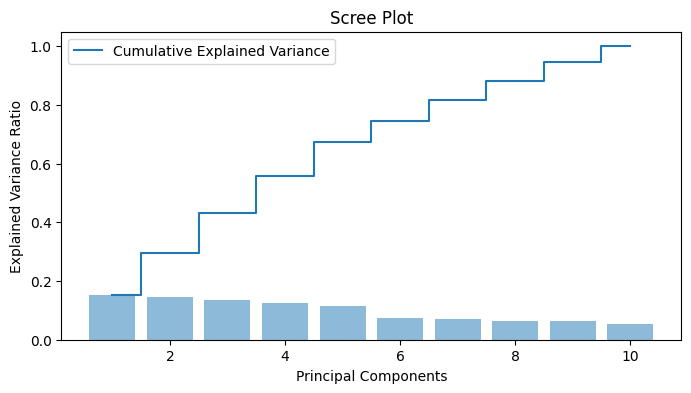

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 500
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2.0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Perform PCA
pca = PCA()
data_pca = pca.fit_transform(data)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratios for Principal Components:")
print(explained_variance_ratio)

# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nCumulative Explained Variance for Principal Components:")
print(cumulative_explained_variance)

# Scree Plot
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2.0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        25
           1       0.39      0.65      0.49        20

    accuracy                           0.40        45
   macro avg       0.41      0.43      0.38        45
weighted avg       0.41      0.40      0.37        45

Classical SVM training time with PCA: 0.002432107925415039 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54        25
           1       0.45      0.50      0.48        20

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 62.252586126327515 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43        25
           1       0.26      0.25      0.26        20

    accuracy                           0.36        45
   macro avg       0.34      0.34      0.34        45
weighted avg       0.35      0.36      0.35        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 32.30073285102844 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.52      0.54        25
           1       0.45      0.50      0.48        20

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 174.58329963684082 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        25
           1       0.40      0.40      0.40        20

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.46        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 58.63368272781372 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        25
           1       0.42      0.65      0.51        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.43        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.844730615615845 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.28      0.38        25
           1       0.45      0.75      0.57        20

    accuracy                           0.49        45
   macro avg       0.52      0.52      0.47        45
weighted avg       0.53      0.49      0.46        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 35.08543682098389 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.28      0.37        25
           1       0.44      0.70      0.54        20

    accuracy                           0.47        45
   macro avg       0.49      0.49      0.45        45
weighted avg       0.49      0.47      0.44        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 208.29233527183533 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50        25
           1       0.46      0.60      0.52        20

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.53      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 90.9569776058197 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        25
           1       0.44      0.40      0.42        20

    accuracy                           0.51        45
   macro avg       0.50      0.50      0.50        45
weighted avg       0.51      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 54.39561724662781 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        25
           1       0.48      0.50      0.49        20

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.54      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.921117544174194 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        25
           1       0.30      0.30      0.30        20

    accuracy                           0.38        45
   macro avg       0.37      0.37      0.37        45
weighted avg       0.38      0.38      0.38        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 376.2350437641144 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        25
           1       0.42      0.50      0.45        20

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.48      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 112.04717922210693 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.91      0.40      0.56        25
           1       0.56      0.95      0.70        20

    accuracy                           0.64        45
   macro avg       0.73      0.68      0.63        45
weighted avg       0.75      0.64      0.62        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.88653635978699 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.82      0.36      0.50        25
           1       0.53      0.90      0.67        20

    accuracy                           0.60        45
   macro avg       0.67      0.63      0.58        45
weighted avg       0.69      0.60      0.57        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 39.11997961997986 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        25
           1       0.42      0.65      0.51        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.43        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 259.271115064621 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.28      0.35        25
           1       0.40      0.60      0.48        20

    accuracy                           0.42        45
   macro avg       0.43      0.44      0.42        45
weighted avg       0.44      0.42      0.41        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 190.32058095932007 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.32      0.42        25
           1       0.47      0.75      0.58        20

    accuracy                           0.51        45
   macro avg       0.54      0.54      0.50        45
weighted avg       0.55      0.51      0.49        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.673343658447266 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.50      0.75      0.60        20

    accuracy                           0.56        45
   macro avg       0.58      0.57      0.55        45
weighted avg       0.59      0.56      0.54        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 36.25159955024719 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.43      0.65      0.52        20

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.49      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 417.07531571388245 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.43      0.65      0.52        20

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.49      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 112.08537173271179 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70        25
           1       0.00      0.00      0.00        20

    accuracy                           0.53        45
   macro avg       0.27      0.48      0.35        45
weighted avg       0.30      0.53      0.39        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 50.96483492851257 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 27.626312255859375 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The clas

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 245.19576954841614 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The clas

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 25.004250049591064 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The clas

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        25
           1       0.48      0.70      0.57        20

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 66.91158175468445 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.48      0.53        25
           1       0.48      0.60      0.53        20

    accuracy                           0.53        45
   macro avg       0.54      0.54      0.53        45
weighted avg       0.55      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 44.77684712409973 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        25
           1       0.48      0.50      0.49        20

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.54      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 549.0703999996185 seconds


<ipython-input-15-381d1087cd4e>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        25
           1       0.37      0.35      0.36        20

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 160.30936551094055 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0.5  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        25
           1       0.39      0.65      0.49        20

    accuracy                           0.40        45
   macro avg       0.41      0.43      0.38        45
weighted avg       0.41      0.40      0.37        45

Classical SVM training time with PCA: 0.0035550594329833984 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        25
           1       0.30      0.30      0.30        20

    accuracy                           0.38        45
   macro avg       0.37      0.37      0.37        45
weighted avg       0.38      0.38      0.38        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 59.737123012542725 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60        25
           1       0.47      0.40      0.43        20

    accuracy                           0.53        45
   macro avg       0.52      0.52      0.52        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 34.343079805374146 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        25
           1       0.48      0.50      0.49        20

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.54      0.53      0.53        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 275.24068880081177 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        25
           1       0.42      0.40      0.41        20

    accuracy                           0.49        45
   macro avg       0.48      0.48      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 127.70526909828186 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        25
           1       0.46      0.65      0.54        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.53      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.42740082740784 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        25
           1       0.48      0.70      0.57        20

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 36.27544188499451 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.47      0.70      0.56        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.54      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 283.84948468208313 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.32      0.41        25
           1       0.45      0.70      0.55        20

    accuracy                           0.49        45
   macro avg       0.51      0.51      0.48        45
weighted avg       0.52      0.49      0.47        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 114.55631279945374 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        25
           1       0.39      0.45      0.42        20

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.45        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 53.81922674179077 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        25
           1       0.50      0.50      0.50        20

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.55        45
weighted avg       0.56      0.56      0.56        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 36.34061527252197 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        25
           1       0.42      0.50      0.45        20

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.48      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 282.925541639328 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        25
           1       0.43      0.45      0.44        20

    accuracy                           0.49        45
   macro avg       0.49      0.48      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 98.50509762763977 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.77      0.40      0.53        25
           1       0.53      0.85      0.65        20

    accuracy                           0.60        45
   macro avg       0.65      0.62      0.59        45
weighted avg       0.66      0.60      0.58        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.385315895080566 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.20      0.26        25
           1       0.38      0.60      0.46        20

    accuracy                           0.38        45
   macro avg       0.38      0.40      0.36        45
weighted avg       0.38      0.38      0.35        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 34.44984745979309 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.64      0.62        25
           1       0.50      0.45      0.47        20

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.54        45
weighted avg       0.55      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 430.7452621459961 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        25
           1       0.43      0.80      0.56        20

    accuracy                           0.44        45
   macro avg       0.47      0.48      0.40        45
weighted avg       0.47      0.44      0.38        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 186.60756993293762 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.28      0.37        25
           1       0.44      0.70      0.54        20

    accuracy                           0.47        45
   macro avg       0.49      0.49      0.45        45
weighted avg       0.49      0.47      0.44        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 52.79050946235657 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.50      0.75      0.60        20

    accuracy                           0.56        45
   macro avg       0.58      0.57      0.55        45
weighted avg       0.59      0.56      0.54        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 36.59109687805176 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.36      0.44        25
           1       0.45      0.65      0.53        20

    accuracy                           0.49        45
   macro avg       0.51      0.51      0.48        45
weighted avg       0.51      0.49      0.48        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 167.22375917434692 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        25
           1       0.48      0.70      0.57        20

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 174.9576587677002 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        25
           1       0.44      0.95      0.60        20

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.37735605239868 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        25
           1       0.47      1.00      0.63        20

    accuracy                           0.49        45
   macro avg       0.73      0.54      0.39        45
weighted avg       0.76      0.49      0.36        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 28.929454803466797 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.43      0.95      0.59        20

    accuracy                           0.42        45
   macro avg       0.22      0.47      0.30        45
weighted avg       0.19      0.42      0.26        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 189.59307622909546 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 25.669280767440796 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The clas

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.27      0.16      0.20        25
           1       0.30      0.45      0.36        20

    accuracy                           0.29        45
   macro avg       0.28      0.30      0.28        45
weighted avg       0.28      0.29      0.27        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 67.5393180847168 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49        25
           1       0.44      0.55      0.49        20

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 43.98613238334656 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        25
           1       0.43      0.50      0.47        20

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 281.4693024158478 seconds


<ipython-input-16-382454cfdd42>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        25
           1       0.43      0.50      0.47        20

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 78.25197672843933 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        25
           1       0.43      0.75      0.55        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.42        45
weighted avg       0.47      0.44      0.40        45

Classical SVM training time with PCA: 0.0019044876098632812 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
<ipython-input-3-7af082378acc>:89: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        25
           1       0.40      0.50      0.44        20

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.46      0.44      0.44        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 54.09065103530884 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41        25
           1       0.38      0.50      0.43        20

    accuracy                           0.42        45
   macro avg       0.43      0.43      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 32.327221155166626 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        25
           1       0.35      0.40      0.37        20

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.41      0.40      0.40        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 297.2533824443817 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        25
           1       0.36      0.45      0.40        20

    accuracy                           0.40        45
   macro avg       0.41      0.41      0.40        45
weighted avg       0.41      0.40      0.40        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 97.32155323028564 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        25
           1       0.39      0.65      0.49        20

    accuracy                           0.40        45
   macro avg       0.41      0.43      0.38        45
weighted avg       0.41      0.40      0.37        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 59.03374671936035 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        25
           1       0.42      0.50      0.45        20

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.48      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 29.809499502182007 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        25
           1       0.42      0.65      0.51        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.43        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 251.27509593963623 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18        25
           1       0.39      0.70      0.50        20

    accuracy                           0.38        45
   macro avg       0.36      0.41      0.34        45
weighted avg       0.36      0.38      0.32        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 180.6911859512329 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43        25
           1       0.35      0.40      0.37        20

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.41      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 51.706631898880005 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.36      0.38        25
           1       0.30      0.35      0.33        20

    accuracy                           0.36        45
   macro avg       0.36      0.35      0.35        45
weighted avg       0.36      0.36      0.36        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.69189143180847 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        25
           1       0.36      0.45      0.40        20

    accuracy                           0.40        45
   macro avg       0.41      0.41      0.40        45
weighted avg       0.41      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 472.25183725357056 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.40      0.43        25
           1       0.38      0.45      0.41        20

    accuracy                           0.42        45
   macro avg       0.43      0.43      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 177.80248522758484 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.67      0.08      0.14        25
           1       0.45      0.95      0.61        20

    accuracy                           0.47        45
   macro avg       0.56      0.52      0.38        45
weighted avg       0.57      0.47      0.35        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.14385175704956 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.47      0.70      0.56        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.54      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 36.522974491119385 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.47      0.70      0.56        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.54      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 426.86594104766846 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55        25
           1       0.50      0.65      0.57        20

    accuracy                           0.56        45
   macro avg       0.57      0.56      0.56        45
weighted avg       0.57      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 233.91729021072388 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        25
           1       0.53      0.50      0.51        20

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.57        45
weighted avg       0.58      0.58      0.58        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.74796795845032 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.43      0.65      0.52        20

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.49      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 35.41974401473999 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        25
           1       0.39      0.65      0.49        20

    accuracy                           0.40        45
   macro avg       0.41      0.43      0.38        45
weighted avg       0.41      0.40      0.37        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 252.191401720047 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.20      0.28        25
           1       0.41      0.70      0.52        20

    accuracy                           0.42        45
   macro avg       0.43      0.45      0.40        45
weighted avg       0.44      0.42      0.38        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 153.27713179588318 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.786675691604614 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.45      1.00      0.62        20

    accuracy                           0.47        45
   macro avg       0.73      0.52      0.35        45
weighted avg       0.76      0.47      0.32        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 27.305548191070557 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 277.2211158275604 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.44      1.00      0.62        20

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 63.90135860443115 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        25
           1       0.41      0.60      0.49        20

    accuracy                           0.44        45
   macro avg       0.46      0.46      0.44        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 65.98989391326904 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        25
           1       0.42      0.70      0.53        20

    accuracy                           0.44        45
   macro avg       0.46      0.47      0.43        45
weighted avg       0.47      0.44      0.41        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 41.00986576080322 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.43      0.65      0.52        20

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.49      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 499.526113986969 seconds


<ipython-input-3-7af082378acc>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.47      0.70      0.56        20

    accuracy                           0.51        45
   macro avg       0.53      0.53      0.51        45
weighted avg       0.54      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 142.88442397117615 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62        20
           1       0.00      0.00      0.00        25

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Classical SVM training time with PCA: 0.0023360252380371094 seconds
Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 60.86952328681946 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.85      0.61        20
           1       0.67      0.24      0.35        25

    accuracy                           0.51        45
   macro avg       0.57      0.54      0.48        45
weighted avg       0.58      0.51      0.47        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 32.29150652885437 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.80      0.54        20
           1       0.33      0.08      0.13        25

    accuracy                           0.40        45
   macro avg       0.37      0.44      0.34        45
weighted avg       0.37      0.40      0.31        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 421.0440456867218 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        20
           1       0.40      0.08      0.13        25

    accuracy                           0.42        45
   macro avg       0.41      0.46      0.35        45
weighted avg       0.41      0.42      0.33        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 41.48123574256897 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        20
           1       0.54      0.84      0.66        25

    accuracy                           0.51        45
   macro avg       0.44      0.47      0.41        45
weighted avg       0.45      0.51      0.43        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 51.57066512107849 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.95      0.61        20
           1       0.67      0.08      0.14        25

    accuracy                           0.47        45
   macro avg       0.56      0.52      0.38        45
weighted avg       0.57      0.47      0.35        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 33.59969687461853 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.90      0.58        20
           1       0.33      0.04      0.07        25

    accuracy                           0.42        45
   macro avg       0.38      0.47      0.33        45
weighted avg       0.38      0.42      0.30        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 198.61112070083618 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.95      0.61        20
           1       0.67      0.08      0.14        25

    accuracy                           0.47        45
   macro avg       0.56      0.52      0.38        45
weighted avg       0.57      0.47      0.35        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 24.13643455505371 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        20
           1       0.40      0.08      0.13        25

    accuracy                           0.42        45
   macro avg       0.41      0.46      0.35        45
weighted avg       0.41      0.42      0.33        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 53.50142574310303 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.95      0.59        20
           1       0.00      0.00      0.00        25

    accuracy                           0.42        45
   macro avg       0.22      0.47      0.30        45
weighted avg       0.19      0.42      0.26        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 27.084837198257446 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.95      0.59        20
           1       0.00      0.00      0.00        25

    accuracy                           0.42        45
   macro avg       0.22      0.47      0.30        45
weighted avg       0.19      0.42      0.26        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 238.45914030075073 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.90      0.60        20
           1       0.60      0.12      0.20        25

    accuracy                           0.47        45
   macro avg       0.53      0.51      0.40        45
weighted avg       0.53      0.47      0.38        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 33.56064057350159 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.35      0.44        20
           1       0.61      0.80      0.69        25

    accuracy                           0.60        45
   macro avg       0.59      0.57      0.56        45
weighted avg       0.60      0.60      0.58        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 56.28004169464111 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.85      0.55        20
           1       0.00      0.00      0.00        25

    accuracy                           0.38        45
   macro avg       0.20      0.42      0.27        45
weighted avg       0.18      0.38      0.24        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 34.319639444351196 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 134.00685834884644 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.90      0.59        20
           1       0.50      0.08      0.14        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.36        45
weighted avg       0.47      0.44      0.34        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 69.86589312553406 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.95      0.59        20
           1       0.00      0.00      0.00        25

    accuracy                           0.42        45
   macro avg       0.22      0.47      0.30        45
weighted avg       0.19      0.42      0.26        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 53.45056986808777 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        20
           1       0.71      0.20      0.31        25

    accuracy                           0.51        45
   macro avg       0.59      0.55      0.47        45
weighted avg       0.61      0.51      0.45        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 32.4939820766449 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 153.72947335243225 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 31.301918268203735 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.80      0.58        20
           1       0.60      0.24      0.34        25

    accuracy                           0.49        45
   macro avg       0.53      0.52      0.46        45
weighted avg       0.54      0.49      0.45        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 49.39244866371155 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        20
           1       1.00      0.04      0.08        25

    accuracy                           0.47        45
   macro avg       0.73      0.52      0.35        45
weighted avg       0.76      0.47      0.32        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 31.21158766746521 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.85      0.56        20
           1       0.25      0.04      0.07        25

    accuracy                           0.40        45
   macro avg       0.33      0.45      0.31        45
weighted avg       0.32      0.40      0.29        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 183.7361979484558 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.90      0.60        20
           1       0.60      0.12      0.20        25

    accuracy                           0.47        45
   macro avg       0.53      0.51      0.40        45
weighted avg       0.53      0.47      0.38        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 31.033140420913696 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.90      0.60        20
           1       0.60      0.12      0.20        25

    accuracy                           0.47        45
   macro avg       0.53      0.51      0.40        45
weighted avg       0.53      0.47      0.38        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 64.64169979095459 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        20
           1       0.47      0.28      0.35        25

    accuracy                           0.42        45
   macro avg       0.43      0.44      0.42        45
weighted avg       0.44      0.42      0.41        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 42.14421343803406 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.80      0.56        20
           1       0.50      0.16      0.24        25

    accuracy                           0.44        45
   macro avg       0.47      0.48      0.40        45
weighted avg       0.47      0.44      0.38        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 611.6884076595306 seconds


<ipython-input-4-0602cda8380f>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.95      0.62        20
           1       0.75      0.12      0.21        25

    accuracy                           0.49        45
   macro avg       0.61      0.53      0.41        45
weighted avg       0.62      0.49      0.39        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 88.07512259483337 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.50      0.76      0.60        21
           1       0.62      0.33      0.43        24

    accuracy                           0.53        45
   macro avg       0.56      0.55      0.52        45
weighted avg       0.56      0.53      0.51        45

Classical SVM training time with PCA: 0.0026695728302001953 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        21
           1       0.55      0.67      0.60        24

    accuracy                           0.53        45
   macro avg       0.53      0.52      0.52        45
weighted avg       0.53      0.53      0.52        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 66.84889721870422 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.43      0.47        21
           1       0.57      0.67      0.62        24

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.54        45
weighted avg       0.55      0.56      0.55        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 34.59105658531189 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.48      0.54        21
           1       0.62      0.75      0.68        24

    accuracy                           0.62        45
   macro avg       0.62      0.61      0.61        45
weighted avg       0.62      0.62      0.61        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 168.33526921272278 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        21
           1       0.56      0.62      0.59        24

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.52        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 66.12121438980103 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        21
           1       0.56      0.58      0.57        24

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 52.66433310508728 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40        21
           1       0.50      0.54      0.52        24

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.46        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 36.392982006073 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        21
           1       0.55      0.46      0.50        24

    accuracy                           0.51        45
   macro avg       0.52      0.51      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 325.6419701576233 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33        21
           1       0.50      0.62      0.56        24

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.44        45
weighted avg       0.45      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 26.20688009262085 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        21
           1       0.68      0.62      0.65        24

    accuracy                           0.64        45
   macro avg       0.65      0.65      0.64        45
weighted avg       0.65      0.64      0.64        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 53.52011752128601 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        21
           1       0.60      0.62      0.61        24

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.57        45
weighted avg       0.58      0.58      0.58        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.292529344558716 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        21
           1       0.60      0.75      0.67        24

    accuracy                           0.60        45
   macro avg       0.60      0.59      0.58        45
weighted avg       0.60      0.60      0.59        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 151.12759590148926 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.38      0.44        21
           1       0.57      0.71      0.63        24

    accuracy                           0.56        45
   macro avg       0.55      0.54      0.54        45
weighted avg       0.55      0.56      0.54        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 88.71095132827759 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.43      0.42        21
           1       0.48      0.46      0.47        24

    accuracy                           0.44        45
   macro avg       0.44      0.44      0.44        45
weighted avg       0.45      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.0583233833313 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.43      0.42        21
           1       0.48      0.46      0.47        24

    accuracy                           0.44        45
   macro avg       0.44      0.44      0.44        45
weighted avg       0.45      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 32.0967230796814 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        21
           1       0.46      0.46      0.46        24

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 678.9265496730804 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.33      0.36        21
           1       0.48      0.54      0.51        24

    accuracy                           0.44        45
   macro avg       0.44      0.44      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 100.5531554222107 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.25      0.19      0.22        21
           1       0.41      0.50      0.45        24

    accuracy                           0.36        45
   macro avg       0.33      0.35      0.33        45
weighted avg       0.34      0.36      0.34        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.2875394821167 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.27      0.19      0.22        21
           1       0.43      0.54      0.48        24

    accuracy                           0.38        45
   macro avg       0.35      0.37      0.35        45
weighted avg       0.36      0.38      0.36        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 40.05004525184631 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.43      0.42        21
           1       0.48      0.46      0.47        24

    accuracy                           0.44        45
   macro avg       0.44      0.44      0.44        45
weighted avg       0.45      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 570.0220685005188 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        21
           1       0.68      0.71      0.69        24

    accuracy                           0.67        45
   macro avg       0.67      0.66      0.66        45
weighted avg       0.67      0.67      0.67        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 36.92432761192322 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.76      0.58        21
           1       0.55      0.25      0.34        24

    accuracy                           0.49        45
   macro avg       0.51      0.51      0.46        45
weighted avg       0.51      0.49      0.45        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.63032007217407 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.62      0.52        21
           1       0.50      0.33      0.40        24

    accuracy                           0.47        45
   macro avg       0.47      0.48      0.46        45
weighted avg       0.48      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 27.967722177505493 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        21
           1       0.60      0.12      0.21        24

    accuracy                           0.49        45
   macro avg       0.54      0.51      0.41        45
weighted avg       0.54      0.49      0.40        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 179.07885885238647 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        21
           1       0.56      0.42      0.48        24

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 54.10999608039856 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        21
           1       0.59      0.42      0.49        24

    accuracy                           0.53        45
   macro avg       0.54      0.54      0.53        45
weighted avg       0.55      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 66.65814876556396 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57        21
           1       0.60      0.50      0.55        24

    accuracy                           0.56        45
   macro avg       0.56      0.56      0.56        45
weighted avg       0.56      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 43.72881507873535 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        21
           1       0.53      0.42      0.47        24

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 314.6079843044281 seconds


<ipython-input-5-f30e4751921c>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.52      0.48        21
           1       0.50      0.42      0.45        24

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 139.29368019104004 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SLSQP


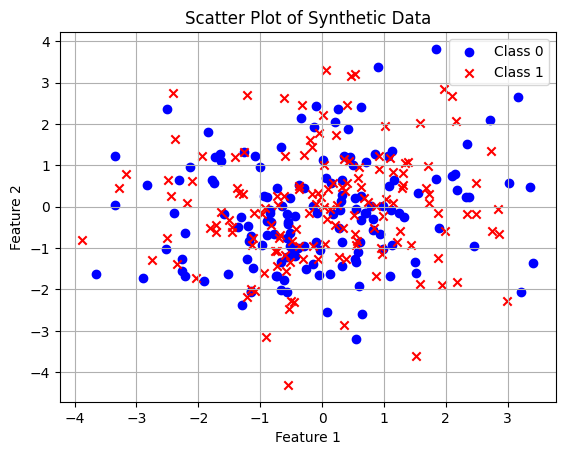

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2.0

data = np.random.multivariate_normal(mean, cov, num_samples)

# Create a scatter plot for the first two dimensions
plt.scatter(data[:, 0], data[:, 1], c='b', marker='o', label='Class 0')
plt.scatter(data[:, 2], data[:, 3], c='r', marker='x', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Synthetic Data')
plt.legend(loc='best')
plt.grid(True)
plt.show()



Explained Variance Ratios for Principal Components:
[0.21749093 0.17343321 0.15707172 0.14911011 0.12842529 0.09528872
 0.07918002]

Cumulative Explained Variance for Principal Components:
[0.21749093 0.39092414 0.54799586 0.69710596 0.82553125 0.92081998
 1.        ]


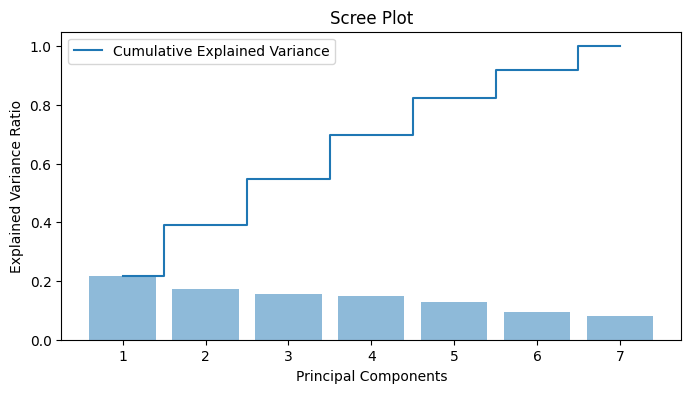

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2.0

data = np.random.multivariate_normal(mean, cov, num_samples)

# Perform PCA
pca = PCA()
data_pca = pca.fit_transform(data)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratios for Principal Components:")
print(explained_variance_ratio)

# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nCumulative Explained Variance for Principal Components:")
print(cumulative_explained_variance)

# Scree Plot
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.title('Scree Plot')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2.0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33        21
           1       0.50      0.62      0.56        24

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.44        45
weighted avg       0.45      0.47      0.45        45

Classical SVM training time with PCA: 0.0016260147094726562 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.67      0.55        21
           1       0.53      0.33      0.41        24

    accuracy                           0.49        45
   macro avg       0.50      0.50      0.48        45
weighted avg       0.50      0.49      0.48        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 56.441521883010864 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        21
           1       0.55      0.46      0.50        24

    accuracy                           0.51        45
   macro avg       0.52      0.51      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 39.27134943008423 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41        21
           1       0.45      0.42      0.43        24

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 196.9184284210205 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.57      0.50        21
           1       0.50      0.38      0.43        24

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.46        45
weighted avg       0.47      0.47      0.46        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 114.44694447517395 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.59      0.79      0.68        24

    accuracy                           0.60        45
   macro avg       0.60      0.59      0.57        45
weighted avg       0.60      0.60      0.58        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.832270860672 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        21
           1       0.53      0.67      0.59        24

    accuracy                           0.51        45
   macro avg       0.50      0.50      0.49        45
weighted avg       0.50      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 37.228312969207764 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        21
           1       0.59      0.79      0.68        24

    accuracy                           0.60        45
   macro avg       0.60      0.59      0.57        45
weighted avg       0.60      0.60      0.58        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 603.2256405353546 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        21
           1       0.62      0.62      0.62        24

    accuracy                           0.60        45
   macro avg       0.60      0.60      0.60        45
weighted avg       0.60      0.60      0.60        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 98.67631602287292 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.48      0.54        21
           1       0.62      0.75      0.68        24

    accuracy                           0.62        45
   macro avg       0.62      0.61      0.61        45
weighted avg       0.62      0.62      0.61        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 54.218932151794434 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.62      0.60        21
           1       0.65      0.62      0.64        24

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.62      0.62      0.62        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.40800666809082 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        21
           1       0.46      0.46      0.46        24

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 405.11815309524536 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        21
           1       0.56      0.42      0.48        24

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 95.09591722488403 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.62      0.53        21
           1       0.53      0.38      0.44        24

    accuracy                           0.49        45
   macro avg       0.50      0.50      0.48        45
weighted avg       0.50      0.49      0.48        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.79500889778137 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        21
           1       0.65      0.54      0.59        24

    accuracy                           0.60        45
   macro avg       0.60      0.60      0.60        45
weighted avg       0.61      0.60      0.60        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 33.55304026603699 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.43      0.40        21
           1       0.43      0.38      0.40        24

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.40      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 270.54991722106934 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53        21
           1       0.57      0.50      0.53        24

    accuracy                           0.53        45
   macro avg       0.54      0.54      0.53        45
weighted avg       0.54      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 161.56823921203613 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.71      0.48      0.57        21
           1       0.65      0.83      0.73        24

    accuracy                           0.67        45
   macro avg       0.68      0.65      0.65        45
weighted avg       0.68      0.67      0.65        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.05091595649719 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.52      0.46        21
           1       0.44      0.33      0.38        24

    accuracy                           0.42        45
   macro avg       0.43      0.43      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 33.229506969451904 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.29      0.32        21
           1       0.46      0.54      0.50        24

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.41      0.42      0.41        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 303.70813393592834 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.27      0.14      0.19        21
           1       0.47      0.67      0.55        24

    accuracy                           0.42        45
   macro avg       0.37      0.40      0.37        45
weighted avg       0.38      0.42      0.38        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 74.31191396713257 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.90      0.59        21
           1       0.00      0.00      0.00        24

    accuracy                           0.42        45
   macro avg       0.22      0.45      0.30        45
weighted avg       0.21      0.42      0.28        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.4311363697052 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        21
           1       0.53      0.67      0.59        24

    accuracy                           0.51        45
   macro avg       0.50      0.50      0.49        45
weighted avg       0.50      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 25.095784425735474 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.67      0.51        21
           1       0.36      0.17      0.23        24

    accuracy                           0.40        45
   macro avg       0.39      0.42      0.37        45
weighted avg       0.39      0.40      0.36        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 244.72486472129822 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.24      0.34        21
           1       0.57      0.88      0.69        24

    accuracy                           0.58        45
   macro avg       0.60      0.56      0.52        45
weighted avg       0.59      0.58      0.53        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 23.76599931716919 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59        21
           1       0.64      0.67      0.65        24

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.62      0.62      0.62        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 67.03370809555054 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.52      0.48        21
           1       0.50      0.42      0.45        24

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 40.100549936294556 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        21
           1       0.57      0.54      0.55        24

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 389.45153737068176 seconds


<ipython-input-6-148d3a0ae6e7>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.43      0.44        21
           1       0.52      0.54      0.53        24

    accuracy                           0.49        45
   macro avg       0.48      0.49      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 162.11721396446228 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 10.0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33        21
           1       0.50      0.62      0.56        24

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.44        45
weighted avg       0.45      0.47      0.45        45

Classical SVM training time with PCA: 0.0017697811126708984 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41        21
           1       0.45      0.42      0.43        24

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 53.96194291114807 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        21
           1       0.53      0.42      0.47        24

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 30.012261390686035 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.57      0.49        21
           1       0.47      0.33      0.39        24

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.44        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 647.8366687297821 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        21
           1       0.47      0.29      0.36        24

    accuracy                           0.44        45
   macro avg       0.45      0.46      0.43        45
weighted avg       0.45      0.44      0.43        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 42.82041358947754 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.24      0.32        21
           1       0.54      0.79      0.64        24

    accuracy                           0.53        45
   macro avg       0.52      0.51      0.48        45
weighted avg       0.52      0.53      0.49        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 53.87793970108032 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        21
           1       0.54      0.54      0.54        24

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.51      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 32.81683564186096 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.66      0.88      0.75        24

    accuracy                           0.69        45
   macro avg       0.71      0.68      0.67        45
weighted avg       0.71      0.69      0.67        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 335.7157037258148 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.24      0.33        21
           1       0.56      0.83      0.67        24

    accuracy                           0.56        45
   macro avg       0.56      0.54      0.50        45
weighted avg       0.56      0.56      0.51        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 84.59672498703003 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.38      0.37        21
           1       0.43      0.42      0.43        24

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.40      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 53.67007899284363 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.67      0.56        21
           1       0.56      0.38      0.45        24

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.53      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 34.27217221260071 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        21
           1       0.53      0.42      0.47        24

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 331.4304645061493 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        21
           1       0.63      0.50      0.56        24

    accuracy                           0.58        45
   macro avg       0.59      0.58      0.58        45
weighted avg       0.59      0.58      0.58        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 110.36867547035217 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        21
           1       0.62      0.42      0.50        24

    accuracy                           0.56        45
   macro avg       0.57      0.57      0.55        45
weighted avg       0.57      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.386523962020874 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49        21
           1       0.52      0.46      0.49        24

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 38.809059619903564 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.62      0.50        21
           1       0.43      0.25      0.32        24

    accuracy                           0.42        45
   macro avg       0.42      0.43      0.41        45
weighted avg       0.42      0.42      0.40        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 161.49686431884766 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        21
           1       0.55      0.46      0.50        24

    accuracy                           0.51        45
   macro avg       0.52      0.51      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 119.46078610420227 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.29      0.35        21
           1       0.53      0.71      0.61        24

    accuracy                           0.51        45
   macro avg       0.50      0.50      0.48        45
weighted avg       0.50      0.51      0.49        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 53.511311769485474 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        21
           1       0.52      0.58      0.55        24

    accuracy                           0.49        45
   macro avg       0.48      0.48      0.48        45
weighted avg       0.48      0.49      0.48        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 35.56785535812378 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.52      0.49        21
           1       0.52      0.46      0.49        24

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 227.93519496917725 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        21
           1       0.56      0.58      0.57        24

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 95.6177864074707 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.43      0.40        21
           1       0.43      0.38      0.40        24

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.40      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.172216176986694 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.33      0.37        21
           1       0.50      0.58      0.54        24

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.45        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 30.609434843063354 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.67      0.56        21
           1       0.56      0.38      0.45        24

    accuracy                           0.51        45
   macro avg       0.52      0.52      0.51        45
weighted avg       0.53      0.51      0.50        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 84.63946342468262 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.57      0.49        21
           1       0.47      0.33      0.39        24

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 33.41906428337097 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        21
           1       0.56      0.62      0.59        24

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.52        45
weighted avg       0.53      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 64.90143322944641 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        21
           1       0.50      0.50      0.50        24

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.46        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 44.27829384803772 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.43      0.44        21
           1       0.52      0.54      0.53        24

    accuracy                           0.49        45
   macro avg       0.48      0.49      0.48        45
weighted avg       0.49      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 538.8764688968658 seconds


<ipython-input-7-731ca240968b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        21
           1       0.54      0.54      0.54        24

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.51      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 163.65922689437866 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XY, Optimizer - L_BFGS_B


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69        47
           1       0.00      0.00      0.00        43

    accuracy                           0.52        90
   macro avg       0.26      0.50      0.34        90
weighted avg       0.27      0.52      0.36        90

Classical SVM training time with PCA: 0.004225492477416992 seconds
Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        47
           1       0.48      0.37      0.42        43

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.51      0.51      0.50        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 122.10531115531921 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51        47
           1       0.42      0.35      0.38        43

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.45      0.46      0.45        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 56.683234214782715 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        47
           1       0.36      0.21      0.26        43

    accuracy                           0.44        90
   macro avg       0.42      0.43      0.41        90
weighted avg       0.42      0.44      0.42        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 318.4502203464508 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.55      0.50        47
           1       0.34      0.26      0.29        43

    accuracy                           0.41        90
   macro avg       0.40      0.40      0.39        90
weighted avg       0.40      0.41      0.40        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 127.07537603378296 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.66      0.56        47
           1       0.38      0.23      0.29        43

    accuracy                           0.46        90
   macro avg       0.43      0.45      0.42        90
weighted avg       0.44      0.46      0.43        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 106.59296655654907 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.87      0.65        47
           1       0.45      0.12      0.19        43

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.42        90
weighted avg       0.49      0.51      0.43        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 52.29519462585449 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.68      0.61        47
           1       0.53      0.40      0.45        43

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.54      0.53        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 489.7695577144623 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.74      0.61        47
           1       0.45      0.23      0.31        43

    accuracy                           0.50        90
   macro avg       0.48      0.49      0.46        90
weighted avg       0.49      0.50      0.46        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 61.85893392562866 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.91      0.65        47
           1       0.20      0.02      0.04        43

    accuracy                           0.49        90
   macro avg       0.35      0.47      0.35        90
weighted avg       0.36      0.49      0.36        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 104.3765823841095 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61        47
           1       0.39      0.16      0.23        43

    accuracy                           0.48        90
   macro avg       0.44      0.46      0.42        90
weighted avg       0.45      0.48      0.43        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 70.00330924987793 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.62      0.52        47
           1       0.31      0.19      0.23        43

    accuracy                           0.41        90
   macro avg       0.38      0.40      0.38        90
weighted avg       0.38      0.41      0.38        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 261.6232159137726 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.70      0.59        47
           1       0.44      0.26      0.32        43

    accuracy                           0.49        90
   macro avg       0.47      0.48      0.46        90
weighted avg       0.48      0.49      0.46        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 49.24552059173584 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.85      0.65        47
           1       0.50      0.16      0.25        43

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.45        90
weighted avg       0.51      0.52      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 110.31754946708679 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.60      0.53        47
           1       0.39      0.28      0.32        43

    accuracy                           0.44        90
   macro avg       0.43      0.44      0.43        90
weighted avg       0.43      0.44      0.43        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 73.93599891662598 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.68      0.58        47
           1       0.44      0.28      0.34        43

    accuracy                           0.49        90
   macro avg       0.48      0.48      0.46        90
weighted avg       0.48      0.49      0.47        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 334.14243602752686 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        47
           1       0.42      0.23      0.30        43

    accuracy                           0.48        90
   macro avg       0.46      0.47      0.44        90
weighted avg       0.46      0.48      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 83.27044415473938 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.98      0.68        47
           1       0.00      0.00      0.00        43

    accuracy                           0.51        90
   macro avg       0.26      0.49      0.34        90
weighted avg       0.27      0.51      0.35        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 104.3309977054596 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        47
           1       0.43      0.30      0.36        43

    accuracy                           0.48        90
   macro avg       0.47      0.47      0.46        90
weighted avg       0.47      0.48      0.46        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 56.16085362434387 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60        47
           1       0.46      0.26      0.33        43

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.47        90
weighted avg       0.49      0.50      0.47        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 217.89889478683472 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62        47
           1       0.50      0.28      0.36        43

    accuracy                           0.52        90
   macro avg       0.52      0.51      0.49        90
weighted avg       0.52      0.52      0.49        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 62.704952001571655 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57        47
           1       0.45      0.30      0.36        43

    accuracy                           0.49        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.48      0.49      0.47        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 96.964346408844 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        47
           1       0.46      0.58      0.52        43

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.48      0.48      0.47        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 58.35795974731445 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.83      0.64        47
           1       0.50      0.19      0.27        43

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.46        90
weighted avg       0.51      0.52      0.47        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 316.51869463920593 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        47
           1       0.46      0.30      0.37        43

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.48        90
weighted avg       0.49      0.50      0.48        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 102.49253630638123 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        47
           1       0.58      0.60      0.59        43

    accuracy                           0.60        90
   macro avg       0.60      0.60      0.60        90
weighted avg       0.60      0.60      0.60        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 129.16532707214355 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.91      0.66        47
           1       0.33      0.05      0.08        43

    accuracy                           0.50        90
   macro avg       0.42      0.48      0.37        90
weighted avg       0.43      0.50      0.38        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 74.01876997947693 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57        47
           1       0.40      0.23      0.29        43

    accuracy                           0.47        90
   macro avg       0.45      0.46      0.43        90
weighted avg       0.45      0.47      0.44        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 344.81136178970337 seconds


<ipython-input-3-de4627b2b43b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.81      0.64        47
           1       0.53      0.23      0.32        43

    accuracy                           0.53        90
   macro avg       0.53      0.52      0.48        90
weighted avg       0.53      0.53      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 153.16243267059326 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZYY, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61        47
           1       0.50      0.30      0.38        43

    accuracy                           0.52        90
   macro avg       0.52      0.51      0.49        90
weighted avg       0.52      0.52      0.50        90

Classical SVM training time with PCA: 0.003061532974243164 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49        47
           1       0.41      0.37      0.39        43

    accuracy                           0.44        90
   macro avg       0.44      0.44      0.44        90
weighted avg       0.44      0.44      0.44        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 105.19593334197998 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        47
           1       0.37      0.30      0.33        43

    accuracy                           0.42        90
   macro avg       0.41      0.42      0.41        90
weighted avg       0.41      0.42      0.42        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 70.36256384849548 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.53      0.51        47
           1       0.42      0.37      0.40        43

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.45      0.46      0.45        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 619.8243553638458 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.60      0.55        47
           1       0.47      0.40      0.43        43

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.50      0.50      0.50        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 174.86254835128784 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        47
           1       0.51      0.49      0.50        43

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.53        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 105.60875725746155 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.51      0.47        47
           1       0.34      0.28      0.31        43

    accuracy                           0.40        90
   macro avg       0.39      0.39      0.39        90
weighted avg       0.39      0.40      0.39        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 70.90386724472046 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.60      0.53        47
           1       0.39      0.28      0.32        43

    accuracy                           0.44        90
   macro avg       0.43      0.44      0.43        90
weighted avg       0.43      0.44      0.43        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 746.9031844139099 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.62      0.56        47
           1       0.47      0.37      0.42        43

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.50      0.49        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 352.21220445632935 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.70      0.60        47
           1       0.48      0.30      0.37        43

    accuracy                           0.51        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.50      0.51      0.49        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 105.02010822296143 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        47
           1       0.50      0.37      0.43        43

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.52      0.51        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 70.2452187538147 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60        47
           1       0.53      0.42      0.47        43

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.54      0.54        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 1567.000002861023 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        47
           1       0.44      0.42      0.43        43

    accuracy                           0.47        90
   macro avg       0.46      0.46      0.46        90
weighted avg       0.47      0.47      0.47        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 207.89180493354797 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        47
           1       0.53      0.37      0.44        43

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.54      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 113.6944088935852 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52        47
           1       0.49      0.51      0.50        43

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.51      0.51      0.51        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 74.85961723327637 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        47
           1       0.51      0.44      0.48        43

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.53        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 496.02721905708313 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.64      0.57        47
           1       0.45      0.33      0.38        43

    accuracy                           0.49        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.48      0.49      0.48        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 216.07412934303284 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41        47
           1       0.44      0.56      0.49        43

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.45        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 106.32780694961548 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.21      0.27        47
           1       0.40      0.58      0.48        43

    accuracy                           0.39        90
   macro avg       0.38      0.40      0.37        90
weighted avg       0.38      0.39      0.37        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 70.95587587356567 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.47      0.45        47
           1       0.38      0.35      0.36        43

    accuracy                           0.41        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.41      0.41      0.41        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 533.1189291477203 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        47
           1       0.39      0.37      0.38        43

    accuracy                           0.42        90
   macro avg       0.42      0.42      0.42        90
weighted avg       0.42      0.42      0.42        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 239.58525252342224 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.79      0.62        47
           1       0.41      0.16      0.23        43

    accuracy                           0.49        90
   macro avg       0.46      0.48      0.42        90
weighted avg       0.46      0.49      0.43        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 97.76163053512573 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.87      0.65        47
           1       0.45      0.12      0.19        43

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.42        90
weighted avg       0.49      0.51      0.43        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 59.27425789833069 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.83      0.64        47
           1       0.47      0.16      0.24        43

    accuracy                           0.51        90
   macro avg       0.49      0.50      0.44        90
weighted avg       0.49      0.51      0.45        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 621.8444876670837 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        47
           1       0.46      0.51      0.48        43

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.48      0.48      0.48        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 116.08094692230225 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.57      0.51        47
           1       0.38      0.28      0.32        43

    accuracy                           0.43        90
   macro avg       0.42      0.43      0.42        90
weighted avg       0.42      0.43      0.42        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 131.21897435188293 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        47
           1       0.50      0.53      0.52        43

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.52        90
weighted avg       0.52      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 87.01344799995422 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.62      0.56        47
           1       0.47      0.37      0.42        43

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.50      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 438.3848457336426 seconds


<ipython-input-4-df0ed8a22384>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.77      0.65        47
           1       0.59      0.37      0.46        43

    accuracy                           0.58        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.58      0.56        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 307.9899320602417 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZYY, Optimizer - SLSQP


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 10  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61        47
           1       0.50      0.30      0.38        43

    accuracy                           0.52        90
   macro avg       0.52      0.51      0.49        90
weighted avg       0.52      0.52      0.50        90

Classical SVM training time with PCA: 0.002814769744873047 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        47
           1       0.48      0.37      0.42        43

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.51      0.51      0.50        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 106.85857367515564 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60        47
           1       0.53      0.42      0.47        43

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.54      0.54        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 70.3224425315857 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.49      0.52        47
           1       0.51      0.58      0.54        43

    accuracy                           0.53        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.53      0.53        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 277.327112197876 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        47
           1       0.51      0.44      0.48        43

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.53        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 334.33817768096924 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        47
           1       0.41      0.33      0.36        43

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.44        90
weighted avg       0.45      0.46      0.45        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 106.10678935050964 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.55      0.53        47
           1       0.45      0.40      0.42        43

    accuracy                           0.48        90
   macro avg       0.47      0.47      0.47        90
weighted avg       0.47      0.48      0.47        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 70.96322727203369 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51        47
           1       0.45      0.44      0.45        43

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.48      0.48      0.48        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 587.3229875564575 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.83      0.65        47
           1       0.53      0.21      0.30        43

    accuracy                           0.53        90
   macro avg       0.53      0.52      0.47        90
weighted avg       0.53      0.53      0.48        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 252.3496220111847 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        47
           1       0.50      0.40      0.44        43

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 105.80699586868286 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        47
           1       0.48      0.33      0.39        43

    accuracy                           0.51        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.50      0.51      0.50        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 64.26702284812927 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51        47
           1       0.44      0.40      0.41        43

    accuracy                           0.47        90
   macro avg       0.46      0.46      0.46        90
weighted avg       0.46      0.47      0.46        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 607.6109504699707 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60        47
           1       0.52      0.40      0.45        43

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 82.87626385688782 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        47
           1       0.43      0.30      0.36        43

    accuracy                           0.48        90
   macro avg       0.47      0.47      0.46        90
weighted avg       0.47      0.48      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 116.76744604110718 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.57      0.51        47
           1       0.38      0.28      0.32        43

    accuracy                           0.43        90
   macro avg       0.42      0.43      0.42        90
weighted avg       0.42      0.43      0.42        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 75.01245474815369 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.60      0.55        47
           1       0.46      0.37      0.41        43

    accuracy                           0.49        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.48      0.49      0.48        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 624.2332882881165 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.47      0.47        47
           1       0.43      0.44      0.44        43

    accuracy                           0.46        90
   macro avg       0.46      0.45      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 290.6963007450104 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.43      0.48        47
           1       0.50      0.63      0.56        43

    accuracy                           0.52        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.53      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 112.45332527160645 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        47
           1       0.35      0.26      0.30        43

    accuracy                           0.42        90
   macro avg       0.41      0.42      0.40        90
weighted avg       0.41      0.42      0.41        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 71.38739037513733 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44        47
           1       0.37      0.35      0.36        43

    accuracy                           0.40        90
   macro avg       0.40      0.40      0.40        90
weighted avg       0.40      0.40      0.40        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 468.4519920349121 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        47
           1       0.49      0.56      0.52        43

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.51      0.51      0.51        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 213.68825507164001 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        47
           1       0.41      0.21      0.28        43

    accuracy                           0.48        90
   macro avg       0.45      0.47      0.43        90
weighted avg       0.46      0.48      0.44        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 98.5279335975647 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.55      0.94      0.69        47
           1       0.70      0.16      0.26        43

    accuracy                           0.57        90
   macro avg       0.62      0.55      0.48        90
weighted avg       0.62      0.57      0.49        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 53.8291437625885 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59        47
           1       0.41      0.21      0.28        43

    accuracy                           0.48        90
   macro avg       0.45      0.47      0.43        90
weighted avg       0.46      0.48      0.44        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 268.15831327438354 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.66      0.58        47
           1       0.47      0.33      0.38        43

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.48        90
weighted avg       0.49      0.50      0.49        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 139.90047192573547 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        47
           1       0.53      0.49      0.51        43

    accuracy                           0.54        90
   macro avg       0.54      0.54      0.54        90
weighted avg       0.54      0.54      0.54        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 132.54809713363647 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.32      0.39        47
           1       0.48      0.67      0.56        43

    accuracy                           0.49        90
   macro avg       0.50      0.50      0.48        90
weighted avg       0.50      0.49      0.47        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 89.34211421012878 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.49      0.62      0.55        47
           1       0.42      0.30      0.35        43

    accuracy                           0.47        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.47      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 1171.7168190479279 seconds


<ipython-input-5-0ba6ca06b424>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        47
           1       0.42      0.23      0.30        43

    accuracy                           0.48        90
   macro avg       0.46      0.47      0.44        90
weighted avg       0.46      0.48      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 154.40894651412964 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_Y, Optimizer - COBYLA


In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512707 sha256=83fe81227fda94df7bce7101a9a1787c76d9aa1208aac716df706a1

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0.5  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33        21
           1       0.50      0.62      0.56        24

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.44        45
weighted avg       0.45      0.47      0.45        45

Classical SVM training time with PCA: 0.0023734569549560547 seconds


<ipython-input-4-013b4b80cce4>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.33      0.28      0.30        40
           1       0.49      0.56      0.52        50

    accuracy                           0.43        90
   macro avg       0.41      0.42      0.41        90
weighted avg       0.42      0.43      0.42        90

Classical SVM training time with PCA: 0.002953052520751953 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.60      0.53        40
           1       0.59      0.46      0.52        50

    accuracy                           0.52        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.54      0.52      0.52        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 103.6651964187622 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.50      0.45        40
           1       0.52      0.44      0.48        50

    accuracy                           0.47        90
   macro avg       0.47      0.47      0.47        90
weighted avg       0.48      0.47      0.47        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 60.01819562911987 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        40
           1       0.51      0.46      0.48        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 703.8025736808777 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49        40
           1       0.58      0.56      0.57        50

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.53        90
weighted avg       0.54      0.53      0.53        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 161.16088199615479 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.35      0.38        40
           1       0.54      0.60      0.57        50

    accuracy                           0.49        90
   macro avg       0.47      0.47      0.47        90
weighted avg       0.48      0.49      0.48        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 105.70668506622314 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.54      0.38      0.44        40
           1       0.60      0.74      0.66        50

    accuracy                           0.58        90
   macro avg       0.57      0.56      0.55        90
weighted avg       0.57      0.58      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 56.4427490234375 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        40
           1       0.54      0.76      0.63        50

    accuracy                           0.51        90
   macro avg       0.47      0.48      0.45        90
weighted avg       0.48      0.51      0.47        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 504.8179967403412 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.17      0.24        40
           1       0.54      0.76      0.63        50

    accuracy                           0.50        90
   macro avg       0.45      0.47      0.43        90
weighted avg       0.46      0.50      0.45        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 294.88692474365234 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.60      0.53        40
           1       0.60      0.48      0.53        50

    accuracy                           0.53        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.55      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 104.60926032066345 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.45      0.41        40
           1       0.48      0.40      0.43        50

    accuracy                           0.42        90
   macro avg       0.43      0.43      0.42        90
weighted avg       0.43      0.42      0.42        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 64.49026560783386 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.60      0.53        40
           1       0.59      0.46      0.52        50

    accuracy                           0.52        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.54      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 619.2133848667145 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.40      0.39        40
           1       0.49      0.46      0.47        50

    accuracy                           0.43        90
   macro avg       0.43      0.43      0.43        90
weighted avg       0.44      0.43      0.43        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 158.2532444000244 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.53      0.46        40
           1       0.50      0.38      0.43        50

    accuracy                           0.44        90
   macro avg       0.45      0.45      0.44        90
weighted avg       0.46      0.44      0.44        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 111.24459338188171 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49        40
           1       0.57      0.50      0.53        50

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.52      0.51      0.51        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 74.23125958442688 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.72      0.55        40
           1       0.56      0.28      0.37        50

    accuracy                           0.48        90
   macro avg       0.50      0.50      0.46        90
weighted avg       0.51      0.48      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 560.9598178863525 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.53      0.49        40
           1       0.58      0.52      0.55        50

    accuracy                           0.52        90
   macro avg       0.52      0.52      0.52        90
weighted avg       0.53      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 115.55638360977173 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.28      0.37        40
           1       0.59      0.84      0.69        50

    accuracy                           0.59        90
   macro avg       0.59      0.56      0.53        90
weighted avg       0.59      0.59      0.55        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 101.64027404785156 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.20      0.25        40
           1       0.52      0.70      0.60        50

    accuracy                           0.48        90
   macro avg       0.44      0.45      0.43        90
weighted avg       0.44      0.48      0.45        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 62.03573703765869 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        40
           1       0.53      0.68      0.60        50

    accuracy                           0.49        90
   macro avg       0.46      0.47      0.45        90
weighted avg       0.47      0.49      0.47        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 485.6998288631439 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.33      0.39        40
           1       0.57      0.72      0.64        50

    accuracy                           0.54        90
   macro avg       0.53      0.52      0.51        90
weighted avg       0.53      0.54      0.53        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 209.9460780620575 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.50      0.47        40
           1       0.56      0.50      0.53        50

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.51      0.50      0.50        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 94.60970067977905 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        40
           1       0.48      0.52      0.50        50

    accuracy                           0.42        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.42      0.42      0.42        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 60.10192131996155 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.75      0.58        40
           1       0.62      0.32      0.42        50

    accuracy                           0.51        90
   macro avg       0.54      0.54      0.50        90
weighted avg       0.55      0.51      0.49        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 307.4173057079315 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53        40
           1       0.61      0.54      0.57        50

    accuracy                           0.56        90
   macro avg       0.56      0.56      0.55        90
weighted avg       0.56      0.56      0.56        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 41.83038878440857 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.55      0.48        40
           1       0.53      0.40      0.45        50

    accuracy                           0.47        90
   macro avg       0.47      0.48      0.47        90
weighted avg       0.48      0.47      0.47        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 128.9210925102234 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.60      0.53        40
           1       0.60      0.48      0.53        50

    accuracy                           0.53        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.55      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 76.92900156974792 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.53      0.46        40
           1       0.51      0.40      0.45        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.46        90
weighted avg       0.47      0.46      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 610.658992767334 seconds


<ipython-input-7-5bf175d78856>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.38      0.38        40
           1       0.52      0.54      0.53        50

    accuracy                           0.47        90
   macro avg       0.46      0.46      0.46        90
weighted avg       0.46      0.47      0.47        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 94.5021903514862 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 7  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 10  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.33      0.28      0.30        40
           1       0.49      0.56      0.52        50

    accuracy                           0.43        90
   macro avg       0.41      0.42      0.41        90
weighted avg       0.42      0.43      0.42        90

Classical SVM training time with PCA: 0.004920005798339844 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
<ipython-input-2-acf80cc36304>:89: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        40
           1       0.62      0.62      0.62        50

    accuracy                           0.58        90
   macro avg       0.57      0.57      0.57        90
weighted avg       0.58      0.58      0.58        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 126.52088761329651 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        40
           1       0.51      0.46      0.48        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 72.45315861701965 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.42      0.40        40
           1       0.50      0.46      0.48        50

    accuracy                           0.44        90
   macro avg       0.44      0.44      0.44        90
weighted avg       0.45      0.44      0.45        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 446.4346516132355 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        40
           1       0.47      0.42      0.44        50

    accuracy                           0.41        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.42      0.41      0.41        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 324.3662009239197 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.30      0.35        40
           1       0.54      0.66      0.59        50

    accuracy                           0.50        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.48      0.50      0.48        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 110.36073541641235 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.20      0.26        40
           1       0.54      0.74      0.62        50

    accuracy                           0.50        90
   macro avg       0.46      0.47      0.44        90
weighted avg       0.47      0.50      0.46        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 72.96990132331848 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.33      0.41        40
           1       0.60      0.80      0.68        50

    accuracy                           0.59        90
   macro avg       0.58      0.56      0.55        90
weighted avg       0.58      0.59      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 613.1235768795013 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        40
           1       0.61      0.68      0.64        50

    accuracy                           0.58        90
   macro avg       0.57      0.57      0.56        90
weighted avg       0.57      0.58      0.57        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 195.90425205230713 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.38      0.42        40
           1       0.58      0.68      0.62        50

    accuracy                           0.54        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.54      0.54      0.53        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 109.82053446769714 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.53      0.46        40
           1       0.51      0.40      0.45        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.46        90
weighted avg       0.47      0.46      0.45        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 74.78006076812744 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        40
           1       0.47      0.42      0.44        50

    accuracy                           0.41        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.42      0.41      0.41        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 497.1427981853485 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        40
           1       0.51      0.46      0.48        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 146.71070981025696 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.28      0.33        40
           1       0.55      0.70      0.61        50

    accuracy                           0.51        90
   macro avg       0.48      0.49      0.47        90
weighted avg       0.49      0.51      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 116.22847414016724 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        40
           1       0.51      0.46      0.48        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 79.84748983383179 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        40
           1       0.55      0.64      0.59        50

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.51      0.50        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 613.6252160072327 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.47      0.46        40
           1       0.55      0.52      0.54        50

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.50      0.50      0.50        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 333.78416895866394 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.30      0.39        40
           1       0.59      0.82      0.69        50

    accuracy                           0.59        90
   macro avg       0.58      0.56      0.54        90
weighted avg       0.58      0.59      0.56        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 112.87336468696594 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        40
           1       0.56      0.70      0.62        50

    accuracy                           0.53        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 72.45398163795471 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.25      0.30        40
           1       0.52      0.66      0.58        50

    accuracy                           0.48        90
   macro avg       0.45      0.46      0.44        90
weighted avg       0.46      0.48      0.46        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 737.5580611228943 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        40
           1       0.60      0.60      0.60        50

    accuracy                           0.56        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.56      0.56        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 136.3410906791687 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 103.19493126869202 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        40
           1       0.69      0.18      0.29        50

    accuracy                           0.50        90
   macro avg       0.58      0.54      0.45        90
weighted avg       0.59      0.50      0.43        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 60.96700596809387 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.68      0.58        40
           1       0.65      0.48      0.55        50

    accuracy                           0.57        90
   macro avg       0.58      0.58      0.57        90
weighted avg       0.59      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 315.5696222782135 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.60      0.55        40
           1       0.63      0.54      0.58        50

    accuracy                           0.57        90
   macro avg       0.57      0.57      0.57        90
weighted avg       0.58      0.57      0.57        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 104.11977815628052 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.40      0.40        40
           1       0.51      0.50      0.51        50

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 138.84914326667786 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        40
           1       0.62      0.64      0.63        50

    accuracy                           0.58        90
   macro avg       0.57      0.57      0.57        90
weighted avg       0.58      0.58      0.58        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 89.24404406547546 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.42      0.40        40
           1       0.50      0.46      0.48        50

    accuracy                           0.44        90
   macro avg       0.44      0.44      0.44        90
weighted avg       0.45      0.44      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 790.0769770145416 seconds


<ipython-input-2-acf80cc36304>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        40
           1       0.54      0.54      0.54        50

    accuracy                           0.49        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.49      0.49      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 177.40881156921387 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XY, Optimizer - L_BFGS_B


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.53      0.20      0.29        40
           1       0.57      0.86      0.69        50

    accuracy                           0.57        90
   macro avg       0.55      0.53      0.49        90
weighted avg       0.56      0.57      0.51        90

Classical SVM training time with PCA: 0.003719806671142578 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.55      0.51        40
           1       0.58      0.50      0.54        50

    accuracy                           0.52        90
   macro avg       0.52      0.53      0.52        90
weighted avg       0.53      0.52      0.52        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 110.86009311676025 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41        40
           1       0.56      0.64      0.60        50

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.51      0.52      0.51        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 75.44507765769958 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44        40
           1       0.54      0.52      0.53        50

    accuracy                           0.49        90
   macro avg       0.49      0.48      0.48        90
weighted avg       0.49      0.49      0.49        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 441.922732591629 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38        40
           1       0.54      0.62      0.58        50

    accuracy                           0.50        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.49      0.50      0.49        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 120.13710236549377 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        40
           1       0.51      0.46      0.48        50

    accuracy                           0.46        90
   macro avg       0.46      0.46      0.45        90
weighted avg       0.46      0.46      0.46        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 112.09629225730896 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.33      0.34        40
           1       0.49      0.52      0.50        50

    accuracy                           0.43        90
   macro avg       0.42      0.42      0.42        90
weighted avg       0.43      0.43      0.43        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 72.96957921981812 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.25      0.30        40
           1       0.52      0.66      0.58        50

    accuracy                           0.48        90
   macro avg       0.45      0.46      0.44        90
weighted avg       0.46      0.48      0.46        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 584.0367617607117 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        40
           1       0.53      0.76      0.62        50

    accuracy                           0.49        90
   macro avg       0.43      0.46      0.41        90
weighted avg       0.44      0.49      0.44        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 243.44175028800964 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        40
           1       0.56      0.54      0.55        50

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.51      0.51      0.51        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 108.78814554214478 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.45      0.41        40
           1       0.49      0.42      0.45        50

    accuracy                           0.43        90
   macro avg       0.44      0.43      0.43        90
weighted avg       0.44      0.43      0.43        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 66.88542795181274 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        40
           1       0.58      0.60      0.59        50

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 375.11136531829834 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        40
           1       0.59      0.68      0.63        50

    accuracy                           0.56        90
   macro avg       0.54      0.54      0.54        90
weighted avg       0.55      0.56      0.55        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 101.82777953147888 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.40      0.43        40
           1       0.57      0.64      0.60        50

    accuracy                           0.53        90
   macro avg       0.52      0.52      0.52        90
weighted avg       0.53      0.53      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 117.58122754096985 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.25      0.32        40
           1       0.56      0.76      0.64        50

    accuracy                           0.53        90
   macro avg       0.51      0.51      0.48        90
weighted avg       0.51      0.53      0.50        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 70.32949471473694 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.29      0.23      0.25        40
           1       0.47      0.56      0.51        50

    accuracy                           0.41        90
   macro avg       0.38      0.39      0.38        90
weighted avg       0.39      0.41      0.40        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 368.50007581710815 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.25      0.34        40
           1       0.58      0.82      0.68        50

    accuracy                           0.57        90
   macro avg       0.55      0.53      0.51        90
weighted avg       0.55      0.57      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 284.8623962402344 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.28      0.35        40
           1       0.57      0.76      0.65        50

    accuracy                           0.54        90
   macro avg       0.52      0.52      0.50        90
weighted avg       0.53      0.54      0.52        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 109.58611965179443 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        40
           1       0.57      0.80      0.67        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.50        90
weighted avg       0.54      0.56      0.52        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 72.57480573654175 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.17      0.24        40
           1       0.54      0.78      0.64        50

    accuracy                           0.51        90
   macro avg       0.47      0.48      0.44        90
weighted avg       0.47      0.51      0.46        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 518.8760232925415 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.25      0.34        40
           1       0.58      0.82      0.68        50

    accuracy                           0.57        90
   macro avg       0.55      0.53      0.51        90
weighted avg       0.55      0.57      0.53        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 157.55490517616272 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 103.02732729911804 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 59.381285667419434 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 359.49482774734497 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 162.32009267807007 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        40
           1       0.62      0.78      0.69        50

    accuracy                           0.61        90
   macro avg       0.61      0.59      0.58        90
weighted avg       0.61      0.61      0.60        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 139.194584608078 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.28      0.36        40
           1       0.58      0.80      0.67        50

    accuracy                           0.57        90
   macro avg       0.55      0.54      0.52        90
weighted avg       0.55      0.57      0.53        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 81.2730450630188 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.30      0.38        40
           1       0.58      0.78      0.67        50

    accuracy                           0.57        90
   macro avg       0.55      0.54      0.52        90
weighted avg       0.56      0.57      0.54        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 1310.9702851772308 seconds


<ipython-input-3-46e85810c7c2>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.35      0.42        40
           1       0.59      0.74      0.65        50

    accuracy                           0.57        90
   macro avg       0.55      0.54      0.54        90
weighted avg       0.56      0.57      0.55        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 178.88105702400208 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_XYZYY, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.31      0.12      0.18        40
           1       0.53      0.78      0.63        50

    accuracy                           0.49        90
   macro avg       0.42      0.45      0.40        90
weighted avg       0.43      0.49      0.43        90

Classical SVM training time with PCA: 0.007969379425048828 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.42      0.46        40
           1       0.59      0.66      0.62        50

    accuracy                           0.56        90
   macro avg       0.54      0.54      0.54        90
weighted avg       0.55      0.56      0.55        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 111.04358911514282 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40        40
           1       0.57      0.68      0.62        50

    accuracy                           0.53        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 69.13128900527954 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41        40
           1       0.57      0.70      0.63        50

    accuracy                           0.54        90
   macro avg       0.53      0.52      0.52        90
weighted avg       0.53      0.54      0.53        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 613.3391275405884 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        40
           1       0.62      0.82      0.71        50

    accuracy                           0.62        90
   macro avg       0.62      0.60      0.59        90
weighted avg       0.62      0.62      0.60        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 211.6261932849884 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        40
           1       0.59      0.70      0.64        50

    accuracy                           0.57        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 110.19979739189148 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        40
           1       0.60      0.72      0.65        50

    accuracy                           0.58        90
   macro avg       0.57      0.56      0.56        90
weighted avg       0.57      0.58      0.57        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 73.50086164474487 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        40
           1       0.59      0.70      0.64        50

    accuracy                           0.57        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 393.2394106388092 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        40
           1       0.59      0.70      0.64        50

    accuracy                           0.57        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 436.7729344367981 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        40
           1       0.62      0.72      0.67        50

    accuracy                           0.60        90
   macro avg       0.59      0.58      0.58        90
weighted avg       0.59      0.60      0.59        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 110.66316342353821 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41        40
           1       0.57      0.70      0.63        50

    accuracy                           0.54        90
   macro avg       0.53      0.52      0.52        90
weighted avg       0.53      0.54      0.53        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 72.19558000564575 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        40
           1       0.58      0.72      0.64        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.53        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 500.30468010902405 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.40      0.48        40
           1       0.62      0.78      0.69        50

    accuracy                           0.61        90
   macro avg       0.61      0.59      0.58        90
weighted avg       0.61      0.61      0.60        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 234.84489727020264 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.25      0.32        40
           1       0.55      0.74      0.63        50

    accuracy                           0.52        90
   macro avg       0.49      0.49      0.47        90
weighted avg       0.50      0.52      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 116.93497657775879 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.20      0.27        40
           1       0.55      0.78      0.64        50

    accuracy                           0.52        90
   macro avg       0.49      0.49      0.46        90
weighted avg       0.49      0.52      0.48        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 77.68812656402588 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.12      0.21        40
           1       0.57      0.94      0.71        50

    accuracy                           0.58        90
   macro avg       0.60      0.53      0.46        90
weighted avg       0.60      0.58      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 687.9361464977264 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        40
           1       0.52      0.56      0.54        50

    accuracy                           0.47        90
   macro avg       0.45      0.46      0.45        90
weighted avg       0.46      0.47      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 151.8667757511139 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.33      0.42        40
           1       0.60      0.82      0.69        50

    accuracy                           0.60        90
   macro avg       0.60      0.57      0.56        90
weighted avg       0.60      0.60      0.57        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 111.67678236961365 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        40
           1       0.61      0.76      0.68        50

    accuracy                           0.60        90
   macro avg       0.59      0.58      0.57        90
weighted avg       0.59      0.60      0.59        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 77.98553204536438 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        40
           1       0.62      0.82      0.71        50

    accuracy                           0.62        90
   macro avg       0.62      0.60      0.59        90
weighted avg       0.62      0.62      0.60        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 789.6024675369263 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        40
           1       0.62      0.82      0.71        50

    accuracy                           0.62        90
   macro avg       0.62      0.60      0.59        90
weighted avg       0.62      0.62      0.60        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 286.0771687030792 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 101.22360396385193 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 61.62734889984131 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 315.0590877532959 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 171.51496648788452 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.25      0.32        40
           1       0.55      0.74      0.63        50

    accuracy                           0.52        90
   macro avg       0.49      0.49      0.47        90
weighted avg       0.50      0.52      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 138.9375240802765 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.35      0.42        40
           1       0.59      0.74      0.65        50

    accuracy                           0.57        90
   macro avg       0.55      0.54      0.54        90
weighted avg       0.56      0.57      0.55        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 89.27699971199036 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.25      0.32        40
           1       0.55      0.74      0.63        50

    accuracy                           0.52        90
   macro avg       0.49      0.49      0.47        90
weighted avg       0.50      0.52      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 559.4593691825867 seconds


<ipython-input-4-5929963e295d>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.30      0.34        40
           1       0.53      0.64      0.58        50

    accuracy                           0.49        90
   macro avg       0.47      0.47      0.46        90
weighted avg       0.47      0.49      0.48        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 141.5823585987091 seconds
Best Configuration with PCA: Feature Map - ZZFeatureMap, Optimizer - SLSQP


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 10  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.31      0.12      0.18        40
           1       0.53      0.78      0.63        50

    accuracy                           0.49        90
   macro avg       0.42      0.45      0.40        90
weighted avg       0.43      0.49      0.43        90

Classical SVM training time with PCA: 0.005018711090087891 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        40
           1       0.58      0.72      0.64        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.53        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 110.99342679977417 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40        40
           1       0.57      0.68      0.62        50

    accuracy                           0.53        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 60.91332817077637 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.61      0.78      0.68        50

    accuracy                           0.60        90
   macro avg       0.59      0.58      0.57        90
weighted avg       0.59      0.60      0.58        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 650.3977439403534 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        40
           1       0.58      0.72      0.64        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.53        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 271.5778155326843 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        40
           1       0.60      0.72      0.65        50

    accuracy                           0.58        90
   macro avg       0.57      0.56      0.56        90
weighted avg       0.57      0.58      0.57        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 113.09861707687378 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        40
           1       0.58      0.72      0.64        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.53        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 72.91477060317993 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46        40
           1       0.60      0.72      0.65        50

    accuracy                           0.58        90
   macro avg       0.57      0.56      0.56        90
weighted avg       0.57      0.58      0.57        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 862.0213077068329 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.28      0.35        40
           1       0.57      0.76      0.65        50

    accuracy                           0.54        90
   macro avg       0.52      0.52      0.50        90
weighted avg       0.53      0.54      0.52        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 475.1397624015808 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.40      0.44        40
           1       0.58      0.66      0.62        50

    accuracy                           0.54        90
   macro avg       0.53      0.53      0.53        90
weighted avg       0.54      0.54      0.54        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 112.29035973548889 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        40
           1       0.60      0.76      0.67        50

    accuracy                           0.59        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.59      0.57        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 69.94703984260559 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.38      0.42        40
           1       0.57      0.66      0.61        50

    accuracy                           0.53        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 1061.2003371715546 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.51      0.45      0.48        40
           1       0.60      0.66      0.63        50

    accuracy                           0.57        90
   macro avg       0.56      0.56      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 330.6882658004761 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.25      0.03      0.05        40
           1       0.55      0.94      0.69        50

    accuracy                           0.53        90
   macro avg       0.40      0.48      0.37        90
weighted avg       0.41      0.53      0.40        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 111.3420159816742 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.25      0.33        40
           1       0.57      0.78      0.66        50

    accuracy                           0.54        90
   macro avg       0.52      0.52      0.49        90
weighted avg       0.53      0.54      0.51        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 74.74804878234863 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        40
           1       0.51      0.52      0.51        50

    accuracy                           0.46        90
   macro avg       0.45      0.45      0.45        90
weighted avg       0.45      0.46      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 1191.1374883651733 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38        40
           1       0.54      0.62      0.58        50

    accuracy                           0.50        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.49      0.50      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 115.54417014122009 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.12      0.19        40
           1       0.55      0.84      0.66        50

    accuracy                           0.52        90
   macro avg       0.47      0.48      0.43        90
weighted avg       0.47      0.52      0.45        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 105.32406163215637 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.35      0.39        40
           1       0.56      0.66      0.61        50

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.51      0.52      0.51        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 69.8428955078125 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.57      0.33      0.41        40
           1       0.60      0.80      0.68        50

    accuracy                           0.59        90
   macro avg       0.58      0.56      0.55        90
weighted avg       0.58      0.59      0.56        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 346.9124827384949 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        40
           1       0.62      0.82      0.71        50

    accuracy                           0.62        90
   macro avg       0.62      0.60      0.59        90
weighted avg       0.62      0.62      0.60        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 214.60740041732788 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 96.56274771690369 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 52.873191356658936 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 1039.3020248413086 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 119.21319150924683 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.17      0.24        40
           1       0.54      0.78      0.64        50

    accuracy                           0.51        90
   macro avg       0.47      0.48      0.44        90
weighted avg       0.47      0.51      0.46        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 130.48266458511353 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.33      0.39        40
           1       0.58      0.74      0.65        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.52        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 87.01036596298218 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        40
           1       0.58      0.70      0.64        50

    accuracy                           0.56        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.55      0.56      0.54        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 751.6467192173004 seconds


<ipython-input-5-28e107f1dc64>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.20      0.26        40
           1       0.53      0.72      0.61        50

    accuracy                           0.49        90
   macro avg       0.45      0.46      0.43        90
weighted avg       0.46      0.49      0.45        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 273.31377387046814 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - SLSQP


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 2  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.48      0.70      0.57        20
           1       0.62      0.40      0.49        25

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Classical SVM training time with PCA: 0.002789735794067383 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
<ipython-input-3-d23e3c07810b>:89: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        20
           1       0.62      0.64      0.63        25

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.57        45
weighted avg       0.58      0.58      0.58        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 68.45325016975403 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.30      0.32        20
           1       0.50      0.56      0.53        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.43      0.44      0.44        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 34.012609004974365 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        20
           1       0.52      0.56      0.54        25

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.45        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 257.99689745903015 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.50      0.52      0.51        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 56.907087087631226 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.40      0.37        20
           1       0.45      0.40      0.43        25

    accuracy                           0.40        45
   macro avg       0.40      0.40      0.40        45
weighted avg       0.41      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.34021353721619 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        20
           1       0.48      0.52      0.50        25

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 31.527994394302368 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        20
           1       0.48      0.44      0.46        25

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 388.4014232158661 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        20
           1       0.48      0.44      0.46        25

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 219.5521628856659 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        20
           1       0.59      0.64      0.62        25

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.54        45
weighted avg       0.55      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 54.02186131477356 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.50      0.52      0.51        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 30.818870782852173 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        20
           1       0.59      0.64      0.62        25

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.54        45
weighted avg       0.55      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 396.3433167934418 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.35      0.35        20
           1       0.48      0.48      0.48        25

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 74.46220064163208 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        20
           1       0.55      0.44      0.49        25

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.24837303161621 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        20
           1       0.48      0.44      0.46        25

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 38.59904980659485 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.50      0.47        20
           1       0.55      0.48      0.51        25

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 589.7572124004364 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        20
           1       0.57      0.48      0.52        25

    accuracy                           0.51        45
   macro avg       0.51      0.52      0.51        45
weighted avg       0.52      0.51      0.51        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 137.7309229373932 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.35      0.30      0.32        20
           1       0.50      0.56      0.53        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.43      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 52.15836954116821 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        20
           1       0.52      0.52      0.52        25

    accuracy                           0.47        45
   macro avg       0.46      0.46      0.46        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 36.65435290336609 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.50      0.52      0.51        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 350.457111120224 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.29      0.25      0.27        20
           1       0.46      0.52      0.49        25

    accuracy                           0.40        45
   macro avg       0.38      0.39      0.38        45
weighted avg       0.39      0.40      0.39        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 260.7233738899231 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 48.837015867233276 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.55      0.44        20
           1       0.40      0.24      0.30        25

    accuracy                           0.38        45
   macro avg       0.38      0.40      0.37        45
weighted avg       0.39      0.38      0.36        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 31.142422914505005 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        20
           1       1.00      0.04      0.08        25

    accuracy                           0.47        45
   macro avg       0.73      0.52      0.35        45
weighted avg       0.76      0.47      0.32        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 236.34707021713257 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.45      0.90      0.60        20
           1       0.60      0.12      0.20        25

    accuracy                           0.47        45
   macro avg       0.53      0.51      0.40        45
weighted avg       0.53      0.47      0.38        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 38.30155372619629 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.60      0.46        20
           1       0.38      0.20      0.26        25

    accuracy                           0.38        45
   macro avg       0.38      0.40      0.36        45
weighted avg       0.38      0.38      0.35        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 65.73337864875793 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.65      0.52        20
           1       0.53      0.32      0.40        25

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.49      0.47      0.45        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 43.54637622833252 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        20
           1       0.53      0.36      0.43        25

    accuracy                           0.47        45
   macro avg       0.48      0.48      0.46        45
weighted avg       0.48      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 425.06447434425354 seconds


<ipython-input-3-d23e3c07810b>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.60      0.49        20
           1       0.50      0.32      0.39        25

    accuracy                           0.44        45
   macro avg       0.46      0.46      0.44        45
weighted avg       0.46      0.44      0.43        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 70.71046471595764 seconds
Best Configuration with PCA: Feature Map - ZZFeatureMap, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 150
num_features = 5  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 10  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.48      0.70      0.57        20
           1       0.62      0.40      0.49        25

    accuracy                           0.53        45
   macro avg       0.55      0.55      0.53        45
weighted avg       0.56      0.53      0.52        45

Classical SVM training time with PCA: 0.0016024112701416016 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.59      0.50      0.54        20
           1       0.64      0.72      0.68        25

    accuracy                           0.62        45
   macro avg       0.62      0.61      0.61        45
weighted avg       0.62      0.62      0.62        45

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 53.684903621673584 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.50      0.52      0.51        25

    accuracy                           0.44        45
   macro avg       0.43      0.43      0.43        45
weighted avg       0.44      0.44      0.44        45

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 31.416951656341553 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        20
           1       0.52      0.56      0.54        25

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.45        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 181.63584113121033 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.32      0.30      0.31        20
           1       0.46      0.48      0.47        25

    accuracy                           0.40        45
   macro avg       0.39      0.39      0.39        45
weighted avg       0.40      0.40      0.40        45

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 91.81837487220764 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.26      0.25      0.26        20
           1       0.42      0.44      0.43        25

    accuracy                           0.36        45
   macro avg       0.34      0.34      0.34        45
weighted avg       0.35      0.36      0.35        45

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 54.45221161842346 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        20
           1       0.62      0.72      0.67        25

    accuracy                           0.60        45
   macro avg       0.59      0.58      0.58        45
weighted avg       0.59      0.60      0.59        45

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 35.00591540336609 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.45      0.41        20
           1       0.48      0.40      0.43        25

    accuracy                           0.42        45
   macro avg       0.43      0.43      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 278.31883454322815 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29        20
           1       0.42      0.40      0.41        25

    accuracy                           0.36        45
   macro avg       0.35      0.35      0.35        45
weighted avg       0.36      0.36      0.36        45

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 122.8461561203003 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.30      0.30      0.30        20
           1       0.44      0.44      0.44        25

    accuracy                           0.38        45
   macro avg       0.37      0.37      0.37        45
weighted avg       0.38      0.38      0.38        45

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 54.042426347732544 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        20
           1       0.52      0.60      0.56        25

    accuracy                           0.47        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 35.53696250915527 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.32      0.30      0.31        20
           1       0.46      0.48      0.47        25

    accuracy                           0.40        45
   macro avg       0.39      0.39      0.39        45
weighted avg       0.40      0.40      0.40        45

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 213.54288339614868 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        20
           1       0.48      0.52      0.50        25

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 57.052024602890015 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.85      0.60        20
           1       0.62      0.20      0.30        25

    accuracy                           0.49        45
   macro avg       0.54      0.53      0.45        45
weighted avg       0.55      0.49      0.43        45

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 57.862627029418945 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.35      0.37        20
           1       0.52      0.56      0.54        25

    accuracy                           0.47        45
   macro avg       0.45      0.46      0.45        45
weighted avg       0.46      0.47      0.46        45

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 36.15460157394409 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        20
           1       0.59      0.64      0.62        25

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.54        45
weighted avg       0.55      0.56      0.55        45

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 387.3122527599335 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.48      0.60      0.53        20
           1       0.60      0.48      0.53        25

    accuracy                           0.53        45
   macro avg       0.54      0.54      0.53        45
weighted avg       0.55      0.53      0.53        45

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 100.78172850608826 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.45      0.42        20
           1       0.50      0.44      0.47        25

    accuracy                           0.44        45
   macro avg       0.45      0.45      0.44        45
weighted avg       0.45      0.44      0.45        45

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 54.31977128982544 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        20
           1       0.52      0.68      0.59        25

    accuracy                           0.47        45
   macro avg       0.42      0.44      0.42        45
weighted avg       0.43      0.47      0.44        45

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 34.830891370773315 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        20
           1       0.48      0.52      0.50        25

    accuracy                           0.42        45
   macro avg       0.41      0.41      0.41        45
weighted avg       0.42      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 525.7026643753052 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.31      0.25      0.28        20
           1       0.48      0.56      0.52        25

    accuracy                           0.42        45
   macro avg       0.40      0.41      0.40        45
weighted avg       0.41      0.42      0.41        45

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 153.95745539665222 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.85      0.58        20
           1       0.50      0.12      0.19        25

    accuracy                           0.44        45
   macro avg       0.47      0.48      0.38        45
weighted avg       0.47      0.44      0.36        45

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 49.53456139564514 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.44      1.00      0.62        20
           1       0.00      0.00      0.00        25

    accuracy                           0.44        45
   macro avg       0.22      0.50      0.31        45
weighted avg       0.20      0.44      0.27        45

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 30.216009616851807 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.95      0.60        20
           1       0.50      0.04      0.07        25

    accuracy                           0.44        45
   macro avg       0.47      0.49      0.34        45
weighted avg       0.47      0.44      0.31        45

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 315.88893818855286 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.90      0.61        20
           1       0.67      0.16      0.26        25

    accuracy                           0.49        45
   macro avg       0.56      0.53      0.43        45
weighted avg       0.58      0.49      0.41        45

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 97.2538673877716 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.45      0.43        20
           1       0.52      0.48      0.50        25

    accuracy                           0.47        45
   macro avg       0.47      0.46      0.46        45
weighted avg       0.47      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 67.27861285209656 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.42      0.50      0.45        20
           1       0.52      0.44      0.48        25

    accuracy                           0.47        45
   macro avg       0.47      0.47      0.47        45
weighted avg       0.48      0.47      0.47        45

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 41.21971821784973 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.38      0.45      0.41        20
           1       0.48      0.40      0.43        25

    accuracy                           0.42        45
   macro avg       0.43      0.43      0.42        45
weighted avg       0.43      0.42      0.42        45

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 330.4930760860443 seconds


<ipython-input-4-e35dc642fb79>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        20
           1       0.50      0.36      0.42        25

    accuracy                           0.44        45
   macro avg       0.45      0.46      0.44        45
weighted avg       0.46      0.44      0.44        45

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 143.57428121566772 seconds
Best Configuration with PCA: Feature Map - ZZFeatureMap, Optimizer - SPSA


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0.5  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train_pca, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test_pca)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=2, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train_pca, y_train)
        end = time()

        result_quantum = vqc.predict(X_test_pca)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.31      0.12      0.18        40
           1       0.53      0.78      0.63        50

    accuracy                           0.49        90
   macro avg       0.42      0.45      0.40        90
weighted avg       0.43      0.49      0.43        90

Classical SVM training time with PCA: 0.0040645599365234375 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.28      0.34        40
           1       0.56      0.74      0.64        50

    accuracy                           0.53        90
   macro avg       0.51      0.51      0.49        90
weighted avg       0.52      0.53      0.51        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 107.56073594093323 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        40
           1       0.60      0.76      0.67        50

    accuracy                           0.59        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.59      0.57        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 71.93215274810791 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.61      0.78      0.68        50

    accuracy                           0.60        90
   macro avg       0.59      0.58      0.57        90
weighted avg       0.59      0.60      0.58        90

Quantum SVM training time (ZZFeatureMap, L_BFGS_B) with PCA: 1118.1962707042694 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        40
           1       0.55      0.64      0.59        50

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.51      0.50        90

Quantum SVM training time (ZZFeatureMap, SLSQP) with PCA: 100.71884846687317 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        40
           1       0.59      0.70      0.64        50

    accuracy                           0.57        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, SPSA) with PCA: 109.09111976623535 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.28      0.33        40
           1       0.54      0.68      0.60        50

    accuracy                           0.50        90
   macro avg       0.47      0.48      0.47        90
weighted avg       0.48      0.50      0.48        90

Quantum SVM training time (PauliFeatureMap_XY, COBYLA) with PCA: 72.3838369846344 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        40
           1       0.59      0.70      0.64        50

    accuracy                           0.57        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.57      0.56        90

Quantum SVM training time (PauliFeatureMap_XY, L_BFGS_B) with PCA: 488.0493471622467 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.30      0.36        40
           1       0.56      0.70      0.62        50

    accuracy                           0.52        90
   macro avg       0.50      0.50      0.49        90
weighted avg       0.51      0.52      0.50        90

Quantum SVM training time (PauliFeatureMap_XY, SLSQP) with PCA: 424.5603725910187 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        40
           1       0.56      0.70      0.62        50

    accuracy                           0.53        90
   macro avg       0.51      0.51      0.50        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (PauliFeatureMap_ZZ, SPSA) with PCA: 110.2242259979248 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47        40
           1       0.59      0.64      0.62        50

    accuracy                           0.56        90
   macro avg       0.55      0.55      0.54        90
weighted avg       0.55      0.56      0.55        90

Quantum SVM training time (PauliFeatureMap_ZZ, COBYLA) with PCA: 70.28853869438171 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.33      0.39        40
           1       0.58      0.74      0.65        50

    accuracy                           0.56        90
   macro avg       0.54      0.53      0.52        90
weighted avg       0.54      0.56      0.54        90

Quantum SVM training time (PauliFeatureMap_ZZ, L_BFGS_B) with PCA: 557.7452223300934 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_ZZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.61      0.78      0.68        50

    accuracy                           0.60        90
   macro avg       0.59      0.58      0.57        90
weighted avg       0.59      0.60      0.58        90

Quantum SVM training time (PauliFeatureMap_ZZ, SLSQP) with PCA: 388.0291609764099 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.42      0.44        40
           1       0.57      0.60      0.58        50

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.52      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_XYZ, SPSA) with PCA: 115.74084997177124 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.30      0.35        40
           1       0.55      0.68      0.61        50

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.48        90
weighted avg       0.50      0.51      0.49        90

Quantum SVM training time (PauliFeatureMap_XYZ, COBYLA) with PCA: 73.14700245857239 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.41      0.30      0.35        40
           1       0.54      0.66      0.59        50

    accuracy                           0.50        90
   macro avg       0.48      0.48      0.47        90
weighted avg       0.48      0.50      0.48        90

Quantum SVM training time (PauliFeatureMap_XYZ, L_BFGS_B) with PCA: 624.4231259822845 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09        40
           1       0.56      0.96      0.71        50

    accuracy                           0.56        90
   macro avg       0.53      0.51      0.40        90
weighted avg       0.53      0.56      0.43        90

Quantum SVM training time (PauliFeatureMap_XYZ, SLSQP) with PCA: 218.80216789245605 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.43      0.23      0.30        40
           1       0.55      0.76      0.64        50

    accuracy                           0.52        90
   macro avg       0.49      0.49      0.47        90
weighted avg       0.50      0.52      0.49        90

Quantum SVM training time (PauliFeatureMap_YZ, SPSA) with PCA: 109.73965311050415 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.58      0.28      0.37        40
           1       0.59      0.84      0.69        50

    accuracy                           0.59        90
   macro avg       0.59      0.56      0.53        90
weighted avg       0.59      0.59      0.55        90

Quantum SVM training time (PauliFeatureMap_YZ, COBYLA) with PCA: 72.80582880973816 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.61      0.35      0.44        40
           1       0.61      0.82      0.70        50

    accuracy                           0.61        90
   macro avg       0.61      0.58      0.57        90
weighted avg       0.61      0.61      0.59        90

Quantum SVM training time (PauliFeatureMap_YZ, L_BFGS_B) with PCA: 537.1673774719238 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_YZ, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.36      0.20      0.26        40
           1       0.53      0.72      0.61        50

    accuracy                           0.49        90
   macro avg       0.45      0.46      0.43        90
weighted avg       0.46      0.49      0.45        90

Quantum SVM training time (PauliFeatureMap_YZ, SLSQP) with PCA: 208.84835982322693 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SPSA) with PCA: 101.60036158561707 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, COBYLA) with PCA: 54.24650478363037 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, L_BFGS_B) with PCA: 392.05712151527405 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_Y, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.56      1.00      0.71        50

    accuracy                           0.56        90
   macro avg       0.28      0.50      0.36        90
weighted avg       0.31      0.56      0.40        90

Quantum SVM training time (PauliFeatureMap_Y, SLSQP) with PCA: 47.87805986404419 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class

Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.47      0.35      0.40        40
           1       0.57      0.68      0.62        50

    accuracy                           0.53        90
   macro avg       0.52      0.52      0.51        90
weighted avg       0.52      0.53      0.52        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SPSA) with PCA: 134.58238911628723 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.39      0.23      0.29        40
           1       0.54      0.72      0.62        50

    accuracy                           0.50        90
   macro avg       0.46      0.47      0.45        90
weighted avg       0.47      0.50      0.47        90

Quantum SVM training time (PauliFeatureMap_XYZYY, COBYLA) with PCA: 88.84989261627197 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        40
           1       0.55      0.64      0.59        50

    accuracy                           0.51        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.51      0.50        90

Quantum SVM training time (PauliFeatureMap_XYZYY, L_BFGS_B) with PCA: 610.7038626670837 seconds


<ipython-input-5-8bbc6496d4c1>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (PauliFeatureMap_XYZYY, SLSQP) with PCA:
              precision    recall  f1-score   support

           0       0.46      0.40      0.43        40
           1       0.56      0.62      0.59        50

    accuracy                           0.52        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.52      0.52      0.52        90

Quantum SVM training time (PauliFeatureMap_XYZYY, SLSQP) with PCA: 187.42675495147705 seconds
Best Configuration with PCA: Feature Map - PauliFeatureMap_YZ, Optimizer - L_BFGS_B


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from qiskit import Aer
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP, ADAM
from time import time

# Set the random seed for reproducibility
np.random.seed(0)

# Define the number of samples and features
num_samples = 300
num_features = 10  # You can increase this number to create a higher-dimensional dataset

# Generate random data with strong correlations in the first few features
mean = np.zeros(num_features)
cov = np.eye(num_features)
for i in range(5):
    cov[i, i] = 0.5  # Increase the variance for the first 5 features to make them important

data = np.random.multivariate_normal(mean, cov, num_samples)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.random.choice([0, 1], size=num_samples), test_size=0.3, random_state=42)

# Data Preprocessing
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# # Perform PCA to reduce dimensionality
# pca = PCA(n_components=2)  # You can adjust the number of components as needed
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Train Classical SVM on reduced dataset
classical_svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
start = time()
classical_svm_pca.fit(X_train, y_train)
end = time()
classical_svm_predictions_pca = classical_svm_pca.predict(X_test)
print("Performance Metrics for Classical SVM with PCA:")
print(classification_report(y_test, classical_svm_predictions_pca))
print(f"Classical SVM training time with PCA: {end - start} seconds")

# Define a list of feature maps and their parameters to tune for QSVM
feature_maps = [
    {'name': 'ZZFeatureMap', 'feature_map': ZZFeatureMap(feature_dimension=10, reps=2, entanglement='full')},
    {'name': 'PauliFeatureMap_XY', 'feature_map': PauliFeatureMap(feature_dimension=10, reps=2, paulis=['X', 'Y'], entanglement='full')},
    # {'name': 'PauliFeatureMap_ZZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z', 'ZZ'], entanglement='full')},
    # {'name': 'PauliFeatureMap_XYZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z'], entanglement='full')},
    # {'name': 'PauliFeatureMap_YZ', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y', 'Z'], entanglement='full')},
    # {'name': 'PauliFeatureMap_Y', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Y'], entanglement='full')},
    # {'name': 'PauliFeatureMap_XYZYY', 'feature_map': PauliFeatureMap(feature_dimension=2, reps=2, paulis=['X', 'Y', 'Z', 'YY'], entanglement='full')},
    # Add more feature maps and their parameters to explore
]

# Define a list of optimizer parameters to tune for QSVM
optimizers = [
    {'name': 'SPSA', 'optimizer': SPSA(maxiter=50)},
    {'name': 'COBYLA', 'optimizer': COBYLA(maxiter=100)},
    {'name': 'L_BFGS_B', 'optimizer': L_BFGS_B(maxfun=100, maxiter=100)},
    {'name': 'SLSQP', 'optimizer': SLSQP(maxiter=100)},
    # Add more optimizers and their parameters to explore
]

best_score = 0
best_params = {}

for feature_map_params in feature_maps:
    feature_map_name = feature_map_params['name']
    feature_map = feature_map_params['feature_map']

    for optimizer_params in optimizers:
        optimizer_name = optimizer_params['name']
        optimizer = optimizer_params['optimizer']

        # Train QSVM with the current feature map and optimizer
        backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
        vqc = VQC(feature_map=feature_map, ansatz=None, optimizer=optimizer, quantum_instance=quantum_instance)

        start = time()
        vqc.fit(X_train, y_train)
        end = time()

        result_quantum = vqc.predict(X_test)
        score = accuracy_score(y_test, result_quantum)

        # Print performance metrics and runtime for the current configuration
        print(f"Performance Metrics for Quantum SVM ({feature_map_name}, {optimizer_name}) with PCA:")
        print(classification_report(y_test, result_quantum))
        print(f"Quantum SVM training time ({feature_map_name}, {optimizer_name}) with PCA: {end - start} seconds")

        # Check if the current configuration is the best
        if score > best_score:
            best_score = score
            best_params = {'feature_map': feature_map_name, 'optimizer': optimizer_name}

# Print the best configuration found
print(f"Best Configuration with PCA: Feature Map - {best_params['feature_map']}, Optimizer - {best_params['optimizer']}")


Performance Metrics for Classical SVM with PCA:
              precision    recall  f1-score   support

           0       0.32      0.20      0.25        40
           1       0.51      0.66      0.57        50

    accuracy                           0.46        90
   macro avg       0.41      0.43      0.41        90
weighted avg       0.42      0.46      0.43        90

Classical SVM training time with PCA: 0.0039942264556884766 seconds


<ipython-input-4-a0088814d679>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, SPSA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.53      0.48        40
           1       0.55      0.46      0.50        50

    accuracy                           0.49        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.49      0.49        90

Quantum SVM training time (ZZFeatureMap, SPSA) with PCA: 588.6579668521881 seconds


<ipython-input-4-a0088814d679>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Performance Metrics for Quantum SVM (ZZFeatureMap, COBYLA) with PCA:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43        40
           1       0.55      0.56      0.55        50

    accuracy                           0.50        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.50      0.50      0.50        90

Quantum SVM training time (ZZFeatureMap, COBYLA) with PCA: 384.2107837200165 seconds


<ipython-input-4-a0088814d679>:88: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


KeyboardInterrupt: ignored